# Market Access - Pacific Observatory
This notebook is a template workflow to run a baseline accessibility analysis for the Pacific Observatory. It uses various tools developed by the World Bank's Geospatial Operations Support Team (GOST).

This notebook focuses on a raster-based implementation of market access, using the motorized Global Friction Surface from the [Malaria Atlas Project](https://malariaatlas.org/project-resources/accessibility-to-healthcare/). Additionaly, it uses population data from [World Pop](https://hub.worldpop.org/project/categories?id=3) (Unconstrained UN-Adjusted 2020, 1km resolution).

## Data Download Links
- [World Pop Raster](https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/PNG/png_ppp_2020_1km_Aggregated.tif)
- [Friction Surface](https://malariaatlas.org/geoserver/ows?service=CSW&version=2.0.1&request=DirectDownload&ResourceId=Explorer:2020_motorized_travel_time_to_healthcare)

## 0. Setup
Import various packages required.

In [1]:
import sys, os
from os.path import join, expanduser, exists
import geopandas as gpd
import pandas as pd
from gadm import GADMDownloader
from tqdm import tqdm
import urllib.request

ERROR 1: PROJ: proj_create_from_database: Open of /home/jupyter-wb514197/.conda/envs/ox/share/proj failed


In [2]:
## Visualization tools
# import folium as flm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
from rasterio.plot import show
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

In [3]:
# Raster
import rasterio as rio
import numpy as np
from shapely.geometry import Polygon, box, Point
import skimage.graph as graph

The packages below were developed by GOST. They can be installed to the environment or referenced from a local folder.

In [4]:
sys.path.append(join(expanduser("~"), 'Repos', 'gostrocks', 'src'))
sys.path.append(join(expanduser("~"), 'Repos', 'GOSTNets_Raster', 'src'))
sys.path.append(join(expanduser("~"), 'Repos', 'GOSTnets'))
sys.path.append(join(expanduser("~"), 'Repos', 'GOST_Urban', 'src', 'GOST_Urban'))

In [5]:
import GOSTRocks.rasterMisc as rMisc
import GOSTNetsRaster.market_access as ma
import UrbanRaster as urban

In [6]:
# auto reload
%load_ext autoreload
%autoreload 2

## 1. Data Preparation

In [7]:
# adm0 = gpd.read_file(join(expanduser("~"), 'data', 'pacific', 'Adm0_Pacific_Edit.shp'))
adm1 = gpd.read_file(join(expanduser("~"), 'data', 'pacific', 'PIC_adm1.json'))

In [8]:
countries = adm1['ADM0_NAME'].unique()
countries

array(['Papua New Guinea', 'Kiribati', 'Kingdom of Tonga',
       'Federated States of Micronesia', 'Marshall Islands',
       'Solomon Islands', 'Vanuatu', 'Nauru', 'Palau', 'Tuvalu', 'Samoa',
       'Fiji'], dtype=object)

In [20]:
import country_converter as coco

In [22]:
cc = coco.CountryConverter()
adm1.loc[:, 'iso'] = cc.pandas_convert(series=adm1.ADM0_PCODE, to='ISO3')

In [25]:
for country in countries:
    if country in ['Fiji', 'Kiribati']:
        continue
    else:
        adm1_sel = adm1.loc[adm1['ADM0_NAME'] == country].copy()
        iso = adm1_sel['iso'].values[0]
        print(iso, country)

PNG Papua New Guinea
TON Kingdom of Tonga
FSM Federated States of Micronesia
MHL Marshall Islands
SLB Solomon Islands
VUT Vanuatu
NRU Nauru
PLW Palau
TUV Tuvalu
WSM Samoa


In [9]:
# country = 'Tonga'
# iso = 'ton'
# downloader = GADMDownloader(version="4.0")
# adm0 = downloader.get_shape_data_by_country_name(country_name=country, ad_level=0)

In [16]:
# for idx, row in adm0.iterrows():
#     country = row['WB_ADM0_NA']
#     iso = row['ISO3'].lower()
#     print(idx, country)

In [11]:
# idx = 0
# row = adm0.iloc[idx]
# country = row['WB_ADM0_NA']
# iso = row['ISO3'].lower()
# iso

'fji'

In [60]:
# adm0 = adm0.loc[adm0['ISO3']=='FJI'].copy()

In [62]:
scratch_dir = join(expanduser("~"), 'data', 'market-access', iso)

In [13]:
if not exists(scratch_dir):
    os.mkdir(scratch_dir, mode=0o777) 

In [14]:
wp_url = f'https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/{iso.upper()}/{iso}_ppp_2020_1km_Aggregated.tif'
wp_url

'https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/FJI/fji_ppp_2020_1km_Aggregated.tif'

In [15]:
wp_path = join(expanduser("~"), 'data', 'worldpop', f'{iso}_ppp_2020_1km_Aggregated_UNadj.tif') # Download from link above
wp_path

'/home/jupyter-wb514197/data/worldpop/fji_ppp_2020_1km_Aggregated_UNadj.tif'

In [36]:
urllib.request.urlretrieve(wp_url, wp_path)

('/home/jupyter-wb514197/data/worldpop/fji_ppp_2020_1km_Aggregated_UNadj.tif',
 <http.client.HTTPMessage at 0x70e3d9732ab0>)

### Destinations (Cities)

In this section, we create a geodataframe of cities based on the population data. We follow the [European Comission's Degree of Urbanization methodology](https://ghsl.jrc.ec.europa.eu/degurba.php), which defines urban areas as clusters of 5,000 people with a population density greater than 300 people per sq. km. 

The code below uses the World Pop raster to identify the clusters (contiguous cells that meet the thresholds).

In [16]:
urban_calculator = urban.urbanGriddedPop(wp_path)

In [17]:
urban_extents = urban_calculator.calculateUrban(
    densVal=190, totalPopThresh=5000,  # changed the density value to capute more remote cities
    smooth=True, queen=False, verbose=True
    )

15:08:39	: Read in urban data
15:08:39	: Creating Shape 0


In [18]:
len(urban_extents)

7

In [20]:
# urban_extents.explore()

Convert the urban extents to points using the centroid.

### Ports

In [45]:
# wpi = pd.read_csv("./data/UpdatedPub150.csv")

In [32]:
# wpi.loc[:, "geometry"] = wpi.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)

In [33]:
# wpi = gpd.GeoDataFrame(wpi, geometry='geometry', crs='EPSG:4326')

In [34]:
# wpi = wpi.loc[wpi['Country Code']=="Tonga"].copy()

In [37]:
# m = urban_extents.explore()
# wpi.explore(m=m)
# m

In [21]:
dests = urban_extents.copy()
dests.loc[:, 'geometry'] = dests.geometry.centroid

/tmp/ipykernel_1658446/1562541587.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid


### Friction Surface

Process the travel cost surface from the Malaria Atlas Project, clip the raster to our region of interest.

In [63]:
gfs_path = join(expanduser("~"), 'data', 'friction', '2020_motorized_friction_surface.geotiff') # Download from link above
gfs_rio = rio.open(gfs_path)
out_travel_surface = join(scratch_dir, f"travel_surface_motorized_{iso}.tif")
rMisc.clipRaster(gfs_rio, adm0, out_travel_surface, crop=False)

In [64]:
travel_surf = rio.open(out_travel_surface)
# pop_surf = rio.open(wp_path)

In [65]:
from rasterio.warp import reproject, Resampling, calculate_default_transform

In [66]:
travel_surf.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 43200,
 'height': 985,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.008333333333333333, 0.0, -180.0,
        0.0, -0.008333333333333333, -12.474999999999994)}

In [67]:
dst_crs = 'EPSG:3460'
out_travel_surface

'/home/jupyter-wb514197/data/market-access/fji/travel_surface_motorized_fji.tif'

In [69]:
with rio.open(out_travel_surface) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(join(scratch_dir, f"travel_surface_motorized_{iso}_proj.tif"), 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

RasterioIOError: travel_surface_motorized_fji_proj.tif: Free disk space available is 1666425495552 bytes, whereas 4337125292500 are at least necessary. You can disable this check by defining the CHECK_DISK_FREE_SPACE configuration option to FALSE.

In [74]:
out_pop_clip = join(scratch_dir, f"WP_2020_1km_clip.tif")

In [71]:
out_pop_clip
pop_surf_clip

'/home/jupyter-wb514197/data/market-access/fji/WP_2020_1km_STD_clip.tif'

In [70]:
out_travel_surface

'/home/jupyter-wb514197/data/market-access/fji/travel_surface_motorized_fji.tif'

Try PoP

In [44]:
wp_path

'/home/jupyter-wb514197/data/worldpop/fji_ppp_2020_1km_Aggregated_UNadj.tif'

In [45]:
with rio.open(wp_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rio.open(join(scratch_dir, f"WP_2020_1km_proj.tif"), 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

RasterioIOError: /home/jupyter-wb514197/data/market-access/fji/WP_2020_1km_proj.tif: Free disk space available is 1664895000576 bytes, whereas 3874574475960 are at least necessary. You can disable this check by defining the CHECK_DISK_FREE_SPACE configuration option to FALSE.

Clip

In [46]:
wp_proj_path = join(scratch_dir, f"{iso}_ppp_2020_1km_Aggregated_UNadj_proj.tif")
pop_surf_proj = rio.open(wp_proj_path)

In [54]:
adm0_fji = adm0.loc[adm0['ISO3']=='FJI'].copy()
adm0_fji = adm0_fji.to_crs(dst_crs)

In [55]:
out_pop_clip = join(scratch_dir, f"WP_2020_1km_clip.tif")
rMisc.clipRaster(pop_surf_proj, adm0_fji, out_pop_clip, crop=False)

In [56]:
pop_surf_clip = rio.open(out_pop_clip)

In [58]:
pop_surf_clip.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 785,
 'height': 1378,
 'count': 1,
 'crs': CRS.from_epsg(3460),
 'transform': Affine(659.6981137784882, 0.0, 1800287.2032548701,
        0.0, -659.6981137784883, 4499755.301166313)}

In [102]:
reproject?

Signature:
reproject(
    source,
    destination=None,
    src_transform=None,
    gcps=None,
    rpcs=None,
    src_crs=None,
    src_nodata=None,
    dst_transform=None,
    dst_crs=None,
    dst_nodata=None,
    dst_resolution=None,
    src_alpha=0,
    dst_alpha=0,
    resampling=<Resampling.nearest: 0>,
    num_threads=1,
    init_dest_nodata=True,
    warp_mem_limit=0,
    **kwargs,
)
Docstring:
Reproject a source raster to a destination raster.

If the source and destination are ndarrays, coordinate reference
system definitions and affine transformation parameters or ground
control points (gcps) are required for reprojection.

If the source and destination are rasterio Bands, shorthand for
bands of datasets on disk, the coordinate reference systems and
transforms or GCPs will be read from the appropriate datasets.

Parameters
------------
source: ndarray or Band
    The source is a 2 or 3-D ndarray, or a single or a multiple
    Rasterio Band object. The dimensionality of sourc

In [76]:
with rio.open(out_travel_surface) as src:

    with rio.open(out_pop_clip) as template:
    # transform, width, height = calculate_default_transform(
    #     src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = template.meta.copy()
        transform = template.transform
        # kwargs.update({
        #     'crs': dst_crs,
        #     'transform': transform,
        #     'width': width,
        #     'height': height
        # })

    out_travel_surface_std = join(scratch_dir, f"travel_surface_motorized_{iso}_STD.tif")
    with rio.open(out_travel_surface_std, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [68]:
# out_pop_surface_std = join(expanduser("~"), 'data', 'worldpop', "WP_2020_1km_STD.tif")
# out_pop_surface_std = join(scratch_dir, "WP_2020_1km_STD.tif")
out_travel_surface_std = join(scratch_dir, f"travel_surface_motorized_{iso}_STD.tif")
# rMisc.standardizeInputRasters(travel_surf, pop_surf_clip, out_travel_surface_std, resampling_type="nearest")

# rMisc.standardizeInputRasters(travel_surf, pop_surf_proj, out_travel_surface_std, resampling_type="nearest")


[array([[[0.00316, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
         [0.00316, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
         [0.00316, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
         ...,
         [0.00316, 0.00316, 0.00316, ..., 0.00316, 0.00316, 0.00316],
         [0.00316, 0.00316, 0.00316, ..., 0.00316, 0.00316, 0.00316],
         [0.     , 0.     , 0.     , ..., 0.00316, 0.00316, 0.00316]]],
       dtype=float32),
 {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -9999.0,
  'width': 785,
  'height': 1378,
  'count': 1,
  'crs': CRS.from_epsg(3460),
  'transform': Affine(659.6981137784882, 0.0, 1800287.2032548701,
         0.0, -659.6981137784883, 4499755.301166313)}]

Align the population raster to the friction surface, ensuring that they have the same extent and resolution.

In [77]:
# out_pop_surface_std = join(expanduser("~"), 'data', 'worldpop', "WP_2020_1km_STD.tif")
# out_pop_surface_std = join(scratch_dir, "WP_2020_1km_STD.tif")
# rMisc.standardizeInputRasters(pop_surf, travel_surf, out_pop_surface_std, resampling_type="nearest")

### Origins

We prepare a standard grid using each cell from the 1km World Pop raster.

In [132]:
pop_surf = rio.open(out_pop_clip)
pop = pop_surf.read(1, masked=False)

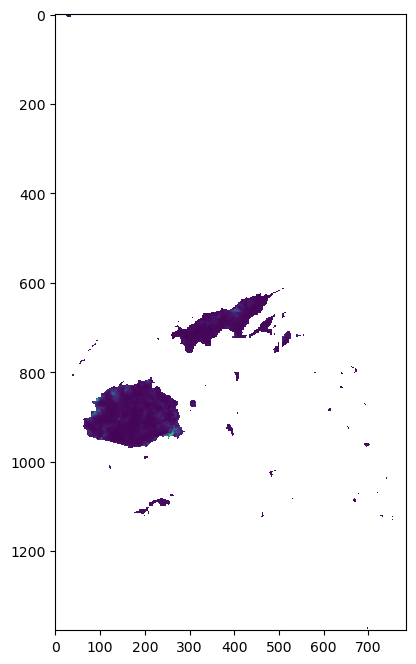

In [133]:
pop_copy = pop.copy()
pop_copy[pop_copy==0] = np.nan
pop_copy[pop_copy==-99999] = np.nan

fig, ax = plt.subplots(figsize=(6,8))
im = ax.imshow(pop_copy, norm=colors.PowerNorm(gamma=0.5), cmap='viridis')

In [88]:
indices = list(np.ndindex(pop.shape))
xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'pop': pop.flatten()
})
res_df['pointid'] = res_df.index

Create an MCP graph object from the friction surface.

In [114]:
travel_surf_std = rio.open(out_travel_surface_std)

In [115]:
# convert friction surface to traversal time (lazily). Original data are
#    are minutes to travel 1 m, so we will convert to 
#    minutes to cross the cell. This could be revised
inG_data = travel_surf_std.read(1) * 1000 

# Correct no data values. Not needed but good to check
# inG_data[inG_data < 0] = 99999999
# inG_data[inG_data < 0] = np.nan
inG_data[inG_data < 0] = inG_data.max()
mcp = graph.MCP_Geometric(inG_data)

In [116]:
# descriptive stats for numpy array
print(f"Mean: {np.mean(inG_data)}")
print(f"Max: {np.max(inG_data)}")
print(f"Min: {np.min(inG_data)}")
print(f"Std: {np.std(inG_data)}")

Mean: 4.363716125488281
Max: 150.3118133544922
Min: 0.9230769276618958
Std: 8.672630310058594


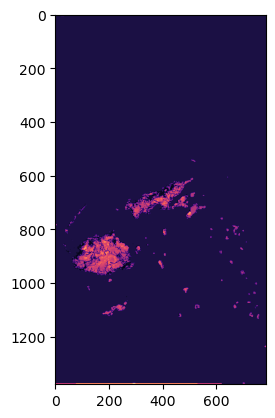

<Axes: >

In [117]:
show(inG_data, norm=colors.PowerNorm(gamma=0.5), cmap='magma')

## 2. Data Analysis

In [147]:
len(res_df), len(dests)

(1081730, 7)

In [148]:
dests = dests.to_crs(dst_crs)

Calculate the travel time from each grid cell to the nearest destination.

In [149]:
res = ma.calculate_travel_time(travel_surf_std, mcp, dests)[0]

In [150]:
res

array([[2590.59121746, 2589.28230256, 2587.97338767, ..., 2560.12322802,
        2561.43214291, 2562.7410578 ],
       [2587.43121737, 2586.12230248, 2584.81338759, ..., 2483.3873213 ,
        2484.69623619, 2486.00515108],
       [2584.27121728, 2582.96230239, 2581.6533875 , ..., 2480.22732121,
        2481.53623611, 2482.845151  ],
       ...,
       [1459.25547082, 1457.94655593, 1456.63764104, ..., 2171.71698477,
        2174.87698486, 2178.03698495],
       [1462.41547091, 1461.10655602, 1459.79764113, ..., 2173.02589967,
        2176.18589975, 2179.34589984],
       [1539.15137763, 1537.84246274, 1536.53354785, ..., 2174.33481456,
        2177.49481465, 2180.65481473]])

In [151]:
len(res.flatten()), len(res_df)

(1081730, 1081730)

In [152]:
res_df.loc[:, 'tt_city_min'] = res.flatten()

In [134]:
res_df.head(3)

,spatial_index,xy,pop,pointid,tt_city_min
0,"(0, 0)",POINT (1800617.0523117594 4499425.4521094235),-99999.0,0,2590.591217
1,"(0, 1)",POINT (1801276.7504255378 4499425.4521094235),-99999.0,1,2589.282303
2,"(0, 2)",POINT (1801936.4485393164 4499425.4521094235),-99999.0,2,2587.973388


In [135]:
# remove values where pop is 0 or nan
res_df = res_df.loc[res_df['pop']!=0].copy()
res_df = res_df.loc[~(res_df['pop'].isna())].copy()

In [136]:
res_df.loc[:,'xy'] = res_df.loc[:,'xy'].apply(lambda x: Point(x))

In [146]:
res_df

/home/jupyter-wb514197/Repos/gostrocks/src/GOSTRocks/rasterMisc.py:52: SyntaxWarning: invalid escape sequence '\W'
  ''' Clip input raster
/home/jupyter-wb514197/Repos/gostrocks/src/GOSTRocks/rasterMisc.py:88: SyntaxWarning: invalid escape sequence '\T'
  ''' Convert input geopandas dataframe into a raster file
/home/jupyter-wb514197/Repos/gostrocks/src/GOSTRocks/rasterMisc.py:523: SyntaxWarning: invalid escape sequence '\G'
  exampleText = '''


,spatial_index,xy,pop,pointid,tt_city_min
0,"(0, 0)",POINT (1800617.0523117594 4499425.4521094235),-99999.0,0,2590.591217
1,"(0, 1)",POINT (1801276.7504255378 4499425.4521094235),-99999.0,1,2589.282303
2,"(0, 2)",POINT (1801936.4485393164 4499425.4521094235),-99999.0,2,2587.973388
3,"(0, 3)",POINT (1802596.1466530948 4499425.4521094235),-99999.0,3,2586.664473
4,"(0, 4)",POINT (1803255.8447668734 4499425.4521094235),-99999.0,4,2585.355558
...,...,...,...,...,...
1081725,"(1377, 780)",POINT (2315181.58105898 3591021.149436445),-99999.0,1081725,2168.014814
1081726,"(1377, 781)",POINT (2315841.2791727586 3591021.149436445),-99999.0,1081726,2171.174814
1081727,"(1377, 782)",POINT (2316500.977286537 3591021.149436445),-99999.0,1081727,2174.334815
1081728,"(1377, 783)",POINT (2317160.675400316 3591021.149436445),-99999.0,1081728,2177.494815


In [139]:
origins = gpd.GeoDataFrame(res_df, geometry='xy', crs=dst_crs) #'EPSG:4326'

In [140]:
origins.rename(columns={'xy':'geometry'}, inplace=True)
origins.set_geometry('geometry', inplace=True)

In [141]:
# convert travel time to hours
origins.loc[:, "tt_city_min_hrs"] = origins.loc[:, "tt_city_min"] / 60

In [142]:
origins.head(2)

,spatial_index,geometry,pop,pointid,tt_city_min,tt_city_min_hrs
0,"(0, 0)",POINT (1800617.052 4499425.452),-99999.0,0,2590.591217,43.176520
1,"(0, 1)",POINT (1801276.750 4499425.452),-99999.0,1,2589.282303,43.154705


Save results as a raster

In [143]:
tt_raster = join(scratch_dir, f"tt_city_min_motorized_friction.tif")

In [145]:
rMisc.rasterizeDataFrame(
    inD = origins,
    outFile = tt_raster,
    idField = 'tt_city_min_hrs',
    templateRaster = out_travel_surface_std
)

## Map Results

In [62]:
tt_rio = rio.open(tt_raster)

In [63]:
os.getcwd()

'/home/jupyter-wb514197/Repos/pacific-access'

In [64]:
# ext_custom = tuple(np.add(ext, (-1, +1, -1, +1)))

In [65]:
# ctx.providers

In [66]:
# ctx.providers.Esri

In [67]:
plt.rcParams["font.family"] = "Ubuntu Condensed"

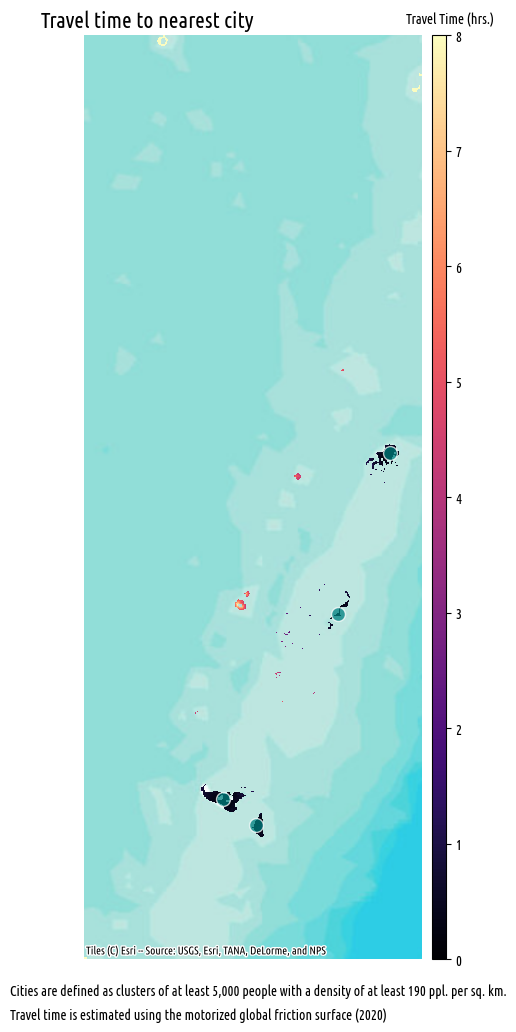

In [75]:
figsize = (12, 12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)

ax.set_title("Travel time to nearest city", fontsize=16, horizontalalignment='right')
plt.axis('off')
ext = plotting_extent(tt_rio)
im = ax.imshow(tt_rio.read(1), vmin=0, vmax=8, cmap='magma', extent=ext)
dests.plot(ax=ax, facecolor='teal', edgecolor='white', markersize=100, alpha=0.75)
# wpi.plot(ax=ax, facecolor='red', edgecolor='black', markersize=25, alpha=0.75)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="4%", pad=0.1)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326', zorder=-1)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTerrain, crs='EPSG:4326', zorder=-1)
txt="Cities are defined as clusters of at least 5,000 people with a density of at least 190 ppl. per sq. km."
txt2 = "Travel time is estimated using the motorized global friction surface (2020)"

plt.figtext(0.3, 0.08, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.3, 0.06, txt2, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.63, 0.89, "Travel Time (hrs.)", wrap=False, fontsize=10)
plt.savefig(f"travel-time-friction-{iso}.png", dpi=300, bbox_inches='tight', facecolor='white')

In [125]:
# import matplotlib.font_manager
# flist = matplotlib.font_manager.get_font_names()
# print(flist)